# Climate Wavers Disaster Magnitude Analysis Model
##       waverX-Analysis

## Install Requirements
- pandas
- numpy
- matplotlib
- scikit-learn
- joblib
- modin
- flask
- flask_cors
- gunicorn
- requests

In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 101 kB 21.1 MB/s ta 0:00:01
     |████████████████████████████████| 80 kB 77.6 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 38.7 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 77.3 MB/s eta 0:00:01
     |████████████████████████████████| 124 kB 102.5 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 7.3 MB/s  eta 0:00:01
     |████████████████████████████████| 136 kB 105.9 MB/s eta 0:00:01
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1


## Data Preparation

Historical disasters data from 2000 - 2023 was pulled from the NOAA site to use for this model

### Data Cleaning
Historical dataset was cleaned off rows without values for Longitude and Latitude columns

In [60]:
# Clean the dataset by filtering out rows with missing or empty longitude and latitude values
import pandas as pd


def clean_disaster_csv(file):
    # Read CSV file into a DataFrame
    df = pd.read_csv(file)

    # Drop rows where longitude or latitude column has missing values
    cleaned_df = df.dropna(subset=['Longitude', 'Latitude'])

    # Write cleaned DataFrame back to a CSV file
    cleaned_df.to_csv(file, index=False)

    print(f"Cleaned disasters historical data saved to {file}")


# Example usage
if __name__ == "__main__":
    # Provide input and output file paths
    base_dir = 'dataset/'
    disaster_dataset = f"{base_dir}historical-disasters.csv"
    # Clean the CSV file
    clean_disaster_csv(disaster_dataset)


Cleaned disasters historical data saved to dataset/historical-disasters.csv


### Dataset Building
Dataset was built buy fetching climate data at the time of disasters from visual crossing API

In [ ]:
import pandas as pd
import requests
from io import StringIO
import asyncio

"""
Fetch climate data at the time of past disasters using the NOAA Climate Data API
to use as our training dataset
"""

# NOAA Climate Data API URL
API_URL = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history/'
API_KEY = ''  # API key


async def fetch_disasters_climate_data() -> bool:
    # Disaster types files to get data
    try:
        # Check if file alrady exist and continue fetching
        climate_dataset_df = pd.read_csv("dataset/" + "climate_data.csv")
    except Exception:
        # Else create a new dataframe
        climate_dataset_df = pd.DataFrame([["Disaster Type", "Magnitude", "Magnitude Scale", "Minimum Temperature", "Maximum Temperature", "Dew Point", "Temperature", "Wind Speed Min", "Wind Speed Max",
                                      "Wind Speed Mean", "Wind Direction", "Relative Humidity Min", "Relative Humidity Max", "Relative Humidity Mean", "Weather Type", "Precipitation", "Cloud Cover", "Sea Level Pressure", "Precipitation Cover"]])
    # Specify the index from which you want to start or continue fetching data
    start_index = 778

    # Read the CSV file and skip the rows before the start_index
    df = pd.read_csv(f'dataset/historical-disasters.csv', skiprows=range(1, start_index))
    # Iterate through the DataFrame using iterrows()
    climate_dataset_df.to_csv("dataset/" + "climate_data.csv", index=False)


    for index, row in df.iterrows():
        # Access columns using column names
        start_year = row['Start Year']
        start_month = row['Start Month']
        start_day = row['Start Day']
        end_year = row['End Year']
        end_month = row['End Month']
        end_day = row['End Day']
        if pd.isna(end_day) or pd.isna(start_day):
            continue
        if pd.isna(end_month) or pd.isna(start_month):
            continue
        print(f"Pulling historical climate data for disaster on {start_year}-{start_month}-{start_day}")
        start_date = "{}-{:02d}-{:02d}T00:00:00".format(
        start_year, int(start_month), int(start_day))
        end_date = "{}-{:02d}-{:02d}T23:59:59".format(
        end_year, int(end_month), int(end_day))

        params = {
            # first location of disaster
            "location": f"{row['Latitude']},{row['Longitude']}",
            "startDateTime": start_date,  # start date of disaster
            "endDateTime": end_date,  # end date of disaster
            "key": API_KEY,
            "aggregateHours": 24,
            "extendedStats": "true",
            "includeAstronomy": "true",
            "contentType": "csv",

        }
        climate_data_req = requests.get(API_URL, params=params)
        if climate_data_req.status_code != 200:
            print("Failed")
            continue
        print("Data pulled successfully")
        climate_data_req = climate_data_req.text
        climate_data_csv = StringIO(climate_data_req)
        data_df = pd.read_csv(climate_data_csv)
        # Filter specific columns
        filtered_df = data_df[["Minimum Temperature", "Maximum Temperature", "Dew Point", "Temperature", "Wind Speed Min", "Wind Speed Max",
                          "Wind Speed Mean", "Wind Direction", "Relative Humidity Min", "Relative Humidity Max", "Relative Humidity Mean", "Weather Type", "Precipitation", "Cloud Cover", "Sea Level Pressure", "Precipitation Cover"]]
        filtered_df.insert(0, "Disaster Type", row["Disaster Type"])
        filtered_df.insert(1, "Magnitude", row["Magnitude"])
        filtered_df.insert(2, "Magnitude Scale", row["Magnitude Scale"])

        print(index)
        filtered_df.to_csv("dataset/" + "climate_data.csv", mode='a', header=False, index=False)


    return True

if __name__ == "__main__":
    asyncio.run(fetch_disasters_climate_data())


## Dataset Cleaning
Clean rows with null and empty values

In [90]:
import pandas as pd

def clean_climate_csv(file):
    # Read CSV file into a DataFrame
    df = pd.read_csv(file)
    # Drop null values
    df.dropna(inplace=True)
    # Write cleaned DataFrame back to a CSV file
    print(f"Cleaned climate dataset in {file}")
    df.to_csv(file, index=False)

    # Example usage
if __name__ == "__main__":
    # Modify file path to your dataset location  
    base_dir = 'dataset/'
    clean_climate_csv(f"{base_dir}climate_data.csv")
    

Cleaned climate dataset in dataset/climate_data.csv


### Data Balancing
Balance disaster magnitude to ensure data magnitude are in same range regardless of their types according to their severity. Flood values in km2 will be divided by highest Km2 value of flood occurred and Storms magnitude in kph will be divided by highest Kph value of storm in dataset and Earthquake richter values divided by 9, highest seen richter value. This values are gotten from analysing data to get the relationship between disaster magnitude scales

In [91]:
import pandas as pd

df = pd.read_csv("dataset/climate_data.csv")


def balance_data(row):
    if row['Magnitude Scale'] == "Km2":
        return row['Magnitude'] / 1600000
    elif row['Magnitude Scale'] == "Kph":
        return row['Magnitude'] / 300
    elif row['Magnitude Scale'] == "Richter":
        return row['Magnitude'] / 9
    else:
        return row['Magnitude']

df['Magnitude'] = df.apply(lambda row: balance_data(row), axis=1)

df.reset_index(drop=True)

df.to_csv("dataset/balanced_climate_data.csv", index=False)

print("Data balanced")


Data balanced


## Model Building and Optimizing with Intel Extension

In [67]:
# Import necessary libraries
import os
import modin.pandas as pd
import modin.config as cfg
import numpy as np
cfg.Engine.put('Ray') 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearnex import patch_sklearn
from sklearn import config_context
from sklearn.metrics import mean_squared_error, r2_score
import joblib



    
patch_sklearn()

# Load disaster climate data
climate_df = pd.read_csv("dataset/balanced_climate_data.csv")

# Drop NaN values
climate_df.dropna(inplace=True)

# Encode  string values
label_encoder = LabelEncoder()
climate_df['Encoded Magnitude Scale'] = label_encoder.fit_transform(climate_df['Magnitude Scale'])
climate_df['Encoded Disaster Type'] = label_encoder.fit_transform(climate_df['Disaster Type'])
climate_df['Encoded Weather Type'] = label_encoder.fit_transform(climate_df['Weather Type'])

training_mse = []
training_cod = []
mse_values = []
cod_values = []
# Prepare features and labels
y = climate_df["Magnitude"]
X = climate_df.drop(columns=["Magnitude", "Magnitude Scale","Disaster Type", "Weather Type"], axis=1)

N_RUNS = 50
TRAIN_SIZE = 0.9
random_state = 777

X = np.ascontiguousarray(X, dtype=np.float64)
y = np.ascontiguousarray(y, dtype=np.float64)

N_RUNS = 50

# Train with Random Forest Regression
rf = RandomForestRegressor(n_estimators=100)

# cross validation
for i in range(N_RUNS):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE,
                                                        random_state=random_state)
    random_state += 777

    # training
    with config_context(assume_finite=True):
        model = rf.fit(X_train, y_train)

    # inference
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    training_mse.append(mean_squared_error(y_train, y_train_pred))
    training_cod.append(r2_score(y_train, y_train_pred))    
    
    mse_values.append(mean_squared_error(y_test, y_pred))
    cod_values.append(r2_score(y_test, y_pred))

# Save the model to a file
joblib.dump(model, 'model/waverX-Analysis.pkl')
print( y_train_pred)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


[0.00322094 0.04842581 0.03487438 ... 0.01325493 0.01258223 0.04101012]


## Evaluate Model

In [68]:

rf_train_mse = sum(training_mse)/len(training_mse)
rf_train_r2 = sum(training_cod)/len(training_cod)

rf_test_mse = sum(mse_values)/len(mse_values)
rf_test_r2 = sum(cod_values)/len(cod_values)

rf_result = pd.DataFrame(['Random Forest', rf_train_mse, rf_test_mse, rf_train_r2, rf_test_r2]).transpose()
rf_result.columns = ["Method", "Training MSE", "Test MSE", "Training R2", "Test R2"]
rf_result

,Method,Training MSE,Test MSE,Training R2,Test R2
0,Random Forest,1.029252,4.283256,0.956761,-27.424645


## Data Visualization


Text(0.5, 0, 'Past Disasters Magnitude')

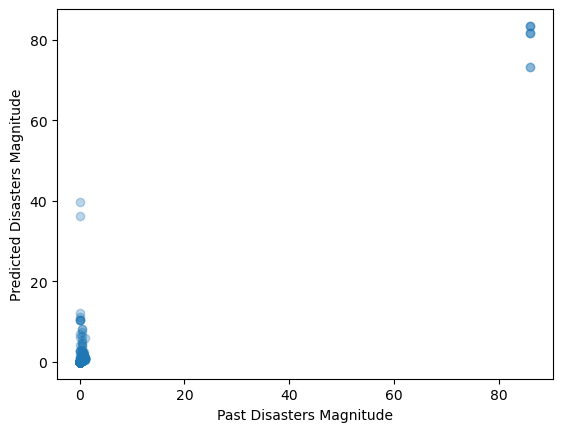

In [69]:
import matplotlib.pyplot as plt
plt.scatter(x=y_train, y=y_train_pred, alpha=0.3)
plt.plot
plt.ylabel("Predicted Disasters Magnitude")
plt.xlabel("Past Disasters Magnitude")

## Inference 

In [13]:
import joblib
from sklearn.preprocessing import LabelEncoder
import requests
from io import StringIO
import numpy as np
import os
import pandas as pd

"""
Run inference on model
"""

# Log server
# Configure the logging settings
logging.basicConfig(filename='waverx_analysis.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(name)s - %(message)s')

# Create a logger instance
logger = logging.getLogger('waverx_nlp')



# Load the model from file
model = joblib.load('model/waverX-Analysis.pkl')

# Set test Visual crossing weather API key
os.environ["API_KEY"]="R9M7HHCH4EDADEUBCU3ZENKXN"

def fetch_climate_data(location, start_date, end_date, disaster_type, api_key):
    """
    Fetching climate data at specified time to run inference
    """
    API_URL = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/'
    
    start_date = "{}T00:00:00Z".format(start_date)
    end_date = "{}T23:59:59Z".format(end_date)
    
    if not api_key:
        api_key = os.getenv("API_KEY")

    params = {
        "location": location,
        "startTime": start_date,  # start date of disaster
        "endTime": end_date,  # end date of disaster
        "key": api_key,
        "include": "days",
        "contentType": "csv",
        "elements": "tempmax,tempmin,dew,temp,windspeedmin,windspeedmax,windspeedmean,winddir,humidity,conditions,precip,cloudcover,pressure,precipcover"
    }
    climate_data_req = requests.get(API_URL, params=params)
    if climate_data_req.status_code != 200:
        print("Fetching climate data failed")
        print(climate_data_req.text)
        return climate_data_req.text
    print("Data pulled successfully")
    climate_data_req = climate_data_req.text
    climate_data_csv = StringIO(climate_data_req)
    data_df = pd.read_csv(climate_data_csv)
    # Filter specific columns
    filtered_df = data_df[["tempmax", "tempmin", "dew", "temp", "windspeedmin", "windspeedmax",
                          "windspeedmean", "winddir", "humidity", "conditions", "precip", "cloudcover", "sealevelpressure", "precipcover"]]
    filtered_df.insert(0, "Disaster Type", disaster_type)
    # Calculate relative humidty min, max and mean
    humidity_min = filtered_df["humidity"] - 2
    humidity_max = filtered_df["humidity"] + 2
    humidity_mean = (humidity_max + humidity_min) / 2
    
    # Set data columns to dataset columns
    dataset_columns = {"tempmin": "Minimum Temperature", "tempmax": "Maximum Temperature", "dew": "Dew Point", "temp": "Temperature", "windspeedmin": "Wind Speed Min",
               "windspeedmax": "Wind Speed Max", "windspeedmean": "Wind Speed Mean", "winddir": "Wind Direction", "conditions": "Weather Type",
               "precip": "Precipitation", "cloudcover": "Cloud Cover", "sealevelpressure": "Sea Level Pressure", "precipcover": "Precipitation Cover"}
    
    filtered_df.rename(columns=dataset_columns, inplace=True)
    filtered_df["Relative Humidity Min"] = humidity_min
    filtered_df["Relative Humidity Max"] = humidity_max
    filtered_df["Relative Humidity Mean"] = humidity_mean
    filtered_df.drop(columns=["humidity"], inplace=True)
    return filtered_df

def predict(location, start_date, end_date, disaster_type, api_key):
    climate_data_df = fetch_climate_data(location, start_date, end_date, disaster_type, api_key)
    if type(climate_data_df) == str:
        print("Prediction failed")
        return climate_data_df
    
    if disaster_type == "Earthquake":
        climate_data_df["Magnitude Scale"] = "Richter"
    elif disaster_type == "Storm":
        climate_data_df["Magnitude Scale"] = "Kph"
    else:
        climate_data_df["Magnitude Scale"] = "Km2"
    # Encode  string values
    label_encoder = LabelEncoder()
    climate_data_df['Encoded Magnitude Scale'] = label_encoder.fit_transform(climate_data_df['Magnitude Scale'])
    climate_data_df['Encoded Disaster Type'] = label_encoder.fit_transform(climate_data_df['Disaster Type'])
    climate_data_df['Encoded Weather Type'] = label_encoder.fit_transform(climate_data_df['Weather Type'])
    
    # Drop NaN values
    climate_data_df.dropna(inplace=True)
    
    X = climate_data_df.drop(columns=["Disaster Type", "Weather Type",  "Magnitude Scale"], axis=1)

    
    predictions = model.predict(X)
    converted_pred = []
    if disaster_type == "Flood":
        # Multiply by 1600000 and divide maximum sea level pressure to get km2 value
        for mag in predictions:
            mag = round((mag * 1600000) / max(climate_data_df['Sea Level Pressure']))
            converted_pred.append(mag)
    elif disaster_type == "Storm":
        # Multiply by 30 to get Kph value
        for mag in predictions:
            mag = round(mag * 300)
            converted_pred.append(mag)
    elif disaster_type == "Earthquake":
        # Multiply by 9 to get richter value
        for mag in predictions:
            mag = round(mag * 9)
            converted_pred.append(mag)
    else:
        converted_pred = predictions
    num_array = np.array(converted_pred)
    min_pred = np.min(num_array)
    max_pred = np.max(num_array)
    print(f"waverX-Analysis model prediction for {disaster_type}")
    print(f"Minimum predicted magnitude: {min_pred} {climate_data_df['Magnitude Scale'][0]}")
    print(f"Maximum predicted magnitude: {max_pred} {climate_data_df['Magnitude Scale'][0]}")

# Example usage
if __name__ == "__main__":
    # Location in Latitude,Longitude format
    # Dates in yyyy-mm-dd format
    predict("80.41,85.9", start_date="2023-01-16", end_date="2023-01-17", disaster_type="Flood", api_key=os.getenv("API_KEY"))

Data pulled successfully
waverX-Analysis model prediction for Flood
Minimum predicted magnitude: 480 Km2
Maximum predicted magnitude: 721 Km2


/opt/app-root/miniconda3/envs/oneAPI-AIKit-MLPackage/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/app-root/miniconda3/envs/oneAPI-AIKit-MLPackage/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/app-root/miniconda3/envs/oneAPI-AIKit-MLPackage/lib/python3.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

## Model Server

In [ ]:
#!/usr/bin/python3
""" Flask Application """

from os import environ
from flask import Flask, jsonify, request, make_response
from flask_cors import CORS
import  prediction
import json

# Configure the logging settings
logging.basicConfig(filename='waverx_analysis.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(name)s - %(message)s')
# Create a logger instance
logger = logging.getLogger('waverx_analysis')

app = Flask(__name__)
app.config['JSONIFY_PRETTYPRINT_REGULAR'] = True
cors = CORS(app, resources={r"/api/v1/*": {"origins": "*"}})

@app.route("/api/v1/analysis/model/waverx", methods=['POST'], strict_slashes=False)
def model_inference():
    location = request.form['location']
    start_date = request.form['startDate']
    end_date = request.form['endDate']
    disaster_type = request.form['disasterType']
    key = request.form["apiKey"]
    return jsonify(prediction.predict(location, start_date, end_date, disaster_type, key))

@app.route("/api/v1/analysis/model/waverx/status", strict_slashes=False)
def model_status():
    return jsonify({"status": "OK"})

@app.errorhandler(404)
def not_found(error):
    """ 404 Error
    ---
    responses:
      404:
        description: a resource was not found
    """
    return make_response(jsonify({'error': "Not found"}), 404)



if __name__ == "__main__":
    """ Main Function """
    host = environ.get('MODEL_HOST')
    port = environ.get('MODEL_PORT')
    if not host:
        host = '0.0.0.0'
    if not port:
        port = '5000'
    app.run(host=host, port=port, threaded=True)
    


 * Serving Flask app '__main__'
 * Debug mode: off
Data pulled successfully
